# IRT Solver: Iterative Refinement in Items + IRF on Simulated Data
We assume that each item measures the same single scale (scalar $\theta$).

To test our non-parametric IRT model, we generate $20$ items with a parameteric form and sample $1-00$ student abilities from the prior distribution (normal) assumed in IRT literature. 

The solver is a continuation outer-loop, gradually refining both the item clustering level and the item response function (optionally). The inner iteration at each level consists of updating IRFs using a histogram and $L_2$ loss minimization estimation of $\theta$.

MSE loss is much faster to minimize than MLE, especially for piecewise constant IRF interpolant. We see convergence only if $\theta$ is normalized to $0$ mean and unit standard deviation (after each step or at the end).


## Observations
* Item clusters are good, they correspond to items of similar difficulty in this case.
* The process converges to a stationary point, but 
* The correlation between the exact $\theta$ and approximate $\hat{\theta}$ is $0.8$, lower than a simple score-based estimation ($0.85$), which is also our initial guess.
* For some $\theta$s, the $L_2$ loss has multiple (typically two) minima of similar value, so the global minimum is not a stable value. Adding $\alpha (\theta-\theta_{current})^2$ regularization term solved this problem, but the overall correlation is the same.
* IRFs have an excellent approximation if the number of bins is small ($4$). If we refine the bins during continuation, kinks develop again, and $corr(\theta, \hat{\theta})$ drops to $0.7$.

Thoughts...
* Is $L_2$ loss good to estimate $\theta$?
* There are multiple IRFs that result in the same $\theta$. Is there a way to regularize them?
* Do we even need to refine the IRFs if they are quite smooth to start with (well, except their steed slope at the transition point)?
* Simulated annealing for $\theta$, or search for loss minimum only in the neighborhood of the current value (or add a regularization term $\alpha (\theta-\theta_{current})^2$, where $\alpha$ is increased during continuation/iterations)? 

## Item Clustering
The idea is to start with a small number of item clusters and gradually refine them to obtain a good initial guess for the original (all-item) problem. We use hierarchical mini-clustering with the distance metric below.

### Distance Metric
Since item vectors are long (of size $P$), clustering in their space is problematic. Instead, we first create shorter items vectors, whose entries correspond to the success of student percentiles of size $L$ on the item instead of individual students:

$$ v_i := \left(v_{i1},\dots,v_{iM}\right)^T\,,\qquad M = [P/L], $$

$$ v_{im} := \frac{1}{|S_m|} \sum_{p \in S_m} x_{im}\,,\qquad m = 1,\dots,M. $$

The distance measure between items $i,i'$ is $d(i,i') := \|v_i-v_{i'}\|_2$. We study the dependence of the *strong* correlations on $L$.

Looks like allowing $L = [P/50]$, i.e., $L = O(P)$ that gives a sufficiently fine resolution in the IRF, gives th same neighbors as $L = 1$.

In [1]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import cntree.cntree
import collections
import logging
import matplotlib.pyplot as plt
import nirt.error
import nirt.irf
import nirt.likelihood
import nirt.mcmc
import nirt.run_recorder
import nirt.simulate.simulate_data
import nirt.simulate.plot_irf
import nirt.solver
import nirt.solver_item_clustering
import nirt.solver_refinement
import numpy as np
import numpy.matlib
import sklearn.metrics
from numpy.linalg import norm, svd

%load_ext autoreload
%autoreload 2

level = logging.INFO
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=level, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

# Deterministic results.
numpy.random.seed(2)

np.set_printoptions(precision=3, linewidth=1000)

In [27]:
# Number of persons.
P = 1000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 1
# Fixed item asymptote (pi) as theta -> -\infty = probability of guessing.
asym = 0 # 0.25
# Constant a for all items.
discrimination = 1

# Binary or continuous students responses.
dichotomous = False

# Type of loss function.
loss = "l2"

## Generate Synthetic Data

In [28]:
# Algorithm parameters.
num_bins = 8
num_iterations = 3
num_theta_sweeps = 5
# Initial simulated annealing temperature.
temperature = 1
# IRF binning strategy.
grid_method = "quantile" # "uniform-fixed" # "quantile" # "uniform" 

In [29]:
X, theta_exact, b, c = nirt.simulate.simulate_data.generate_dichotomous_responses(P, I, C, asymptote=asym, discrimination=discrimination, dichotomous=dichotomous)
model_irf = [lambda t,i=i: nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym) for i in range(I)]
#print("v_exact", v_exact)
print("mean", np.mean(theta_exact, axis=0), "std", np.std(theta_exact, axis=0))

mean [0.03] std [0.974]


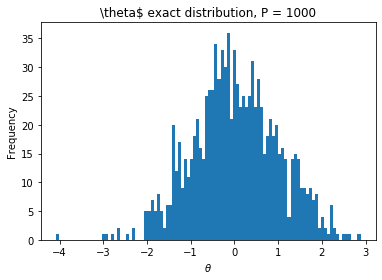

In [30]:
# Verify that student latent abilities are normally distributed. theta_c ~ N(0, invgamma(a_c,b_c))
plt.hist(theta_exact[:, 0], 100)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.title(r"\theta$ exact distribution, P = {}".format(P))
plt.show()

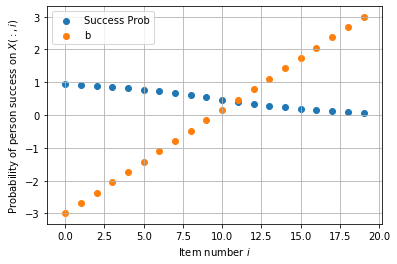

In [31]:
plt.scatter(range(I), np.sum(X, axis=0)/P, label="Success Prob")
plt.scatter(range(I), b, label="b")
plt.xlabel("Item number $i$")
plt.ylabel("Probability of person success on $X(:,i)$")
plt.legend();
plt.grid(True);

### Initial Guess for $\theta$
Initial guess for $\theta_p$: the number of standard deviations person's p's score is away from the average population score.

In [32]:
theta = nirt.likelihood.initial_guess(X, c)
theta = (theta - np.mean(theta, axis=0))/np.std(theta, axis=0)
theta_init = theta

In [33]:
# For each dimension, bin ALL persons by theta values into n bins. Binning strategy is either
# quantiles (so all bins have equal sizes) or uniform grid on a fixed domain [-M,M].
inactive = np.arange(P, dtype=int)
active = np.array([], dtype=int)

xlim = [(min(theta[:, ci])-1, max(theta[:, ci])+1) for ci in range(C)]
grid_all = [nirt.grid.create_grid(theta[:, ci], num_bins, method=grid_method, xlim=xlim[ci]) for ci in range(C)]
irf_all = [nirt.irf.ItemResponseFunction(grid_all[ci], X[:, i]) for i, ci in enumerate(c)]
print("Grid limits", xlim)

Grid limits [(-4.317873571673269, 3.6708341956656247)]


## Item Clustering

In [34]:
bin_size = P // 50
x_coarse = X[nirt.irf.sorted_chunks(X, bin_size)].mean(1)
tree = cntree.cntree.CNTree(debug=1)
clustering = tree.cluster(x_coarse.transpose())
#tree = cntree.cntree.CNTree(debug=1)
#clustering = tree.cluster(X.astype(float).transpose())
# clustering = solver._clustering

for level in [level for level in cntree.cntree.get_clustering_levels(clustering) if level.size <= 0.5 * I]:
    print(level, level.label)

INFO     Level	Nbhrs	Size	cr	mean_sz	std_sz	Time
INFO     1    	2    	2    	10.00  	10.0   	0.0    	0.00
INFO     2    	4    	4    	5.00   	5.0    	1.0    	0.00
INFO     3    	7    	8    	2.50   	2.5    	0.5    	0.00
INFO     4    	7    	16   	1.25   	1.2    	0.4    	0.00
INFO     5    	7    	18   	1.11   	1.1    	0.3    	0.00
INFO     Total						0.02
INFO     Trimming #neighbors to 5


Level 0[size=1,num_neighbors=1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Level 1[size=2,num_neighbors=2] [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Level 2[size=4,num_neighbors=4] [3 3 3 3 3 3 2 2 2 2 0 0 0 0 1 1 1 1 1 1]
Level 3[size=8,num_neighbors=7] [7 7 7 6 6 6 5 5 4 4 1 1 0 0 3 3 3 2 2 2]


Item clusters are good, they correspond to items of similar difficulty in this case.

## Sub-scale Refinement Solver
Refining the item cluster resolution during continuation steps, but keeping the IRF resolution low (4 bins only).

In [60]:
# Run iterative refinement algorithm.
# v is fixed.
alpha = 0.0
recorder = nirt.run_recorder.RunRecorder()
coarsest_resolution = 4
solver = nirt.solver_item_clustering.SolverItemClustering(
    X, c, num_iterations=num_iterations, num_theta_sweeps=num_theta_sweeps, grid_method=grid_method,
    recorder=recorder, finest_resolution=16, coarsest_resolution=coarsest_resolution,
    theta_init=theta_exact, loss=loss, alpha=alpha)

INFO     Level	Nbhrs	Size	cr	mean_sz	std_sz	Time
INFO     1    	2    	2    	10.00  	10.0   	0.0    	0.00
INFO     2    	4    	4    	5.00   	5.0    	1.0    	0.00
INFO     3    	7    	8    	2.50   	2.5    	0.5    	0.00
INFO     4    	7    	16   	1.25   	1.2    	0.4    	0.00
INFO     5    	7    	18   	1.11   	1.1    	0.3    	0.01
INFO     Total						0.02
INFO     Trimming #neighbors to 5


In [61]:
t = solver.solve()

INFO     Initial guess range [-3.32, 2.67] mean 0.00 std 1.00
INFO     Solving at item clustering level with 1 items 4 bins
INFO     Iteration 1/3
INFO     Iteration 2/3
INFO     Iteration 3/3
INFO     Solving at item clustering level with 2 items 4 bins
INFO     Iteration 1/3
INFO     Iteration 2/3
INFO     Iteration 3/3
INFO     Solving at item clustering level with 4 items 4 bins
INFO     Iteration 1/3
INFO     Iteration 2/3
INFO     Iteration 3/3
INFO     Solving at item clustering level with 8 items 4 bins
INFO     Iteration 1/3
INFO     Iteration 2/3
INFO     Iteration 3/3
INFO     Solving at item clustering level with 20 items 4 bins
INFO     Iteration 1/3
INFO     Iteration 2/3
INFO     Iteration 3/3


In [62]:
# Run history: calculate the IRF error from the known parametric model.
logger.info("Initial guess / score-based estimation correlation: {:.3f}".format(
    np.corrcoef(theta_init[:, 0], theta_exact[:, 0])[0, 1]))

for k, (resolution, value) in enumerate(recorder.irf.items()):
    logger.info("#items {}".format(resolution))
    level = solver._clustering[k]
    cluster_model_irf = [
        lambda t, i=i: np.array([model_irf[j](t) for j in level[i]]).mean(0) 
        for i in range(resolution)]
    x = np.array([X[:, cluster].mean(1) for cluster in level]).transpose()

    e = nirt.error.error_norm_by_item(cluster_model_irf, numerical_irf)
    numerical_irf = solver._update_irf(coarsest_resolution, theta_init, x=x)
    l2_loss = nirt.likelihood.Likelihood(x, c, numerical_irf).l2_loss(t)
    logger.info("Initial guess loss {:.5f}".format(l2_loss))

    for j in range(len(value)):
        numerical_irf = value[j]
        e = nirt.error.error_norm_by_item(cluster_model_irf, numerical_irf)
        t = recorder.theta[resolution][j]
        l2_loss = nirt.likelihood.Likelihood(x, c, numerical_irf).l2_loss(t)
        logger.info("IRF error: {:.3f} +- {:.3f}\tt range {:.3f}, {:.3f} corr {:.3f} loss {:.5f}".format(
            e.mean(), e.std(), t.min(), t.max(), 
            np.corrcoef(theta_exact[:, 0], t[:, 0])[0, 1], l2_loss))

INFO     Initial guess / score-based estimation correlation: 0.999
INFO     #items 1
INFO     Initial guess loss 0.00179
INFO     IRF error: 0.059 +- 0.000	t range -3.318, 2.671 corr 0.999 loss 0.00109
INFO     IRF error: 0.032 +- 0.000	t range -2.629, 2.022 corr 0.990 loss 0.00015
INFO     IRF error: 0.032 +- 0.000	t range -2.607, 1.910 corr 0.987 loss 0.00013
INFO     #items 2
INFO     Initial guess loss 0.00185
INFO     IRF error: 0.033 +- 0.015	t range -2.681, 1.825 corr 0.984 loss 0.00015
INFO     IRF error: 0.034 +- 0.016	t range -2.718, 1.799 corr 0.983 loss 0.00017
INFO     IRF error: 0.035 +- 0.016	t range -2.746, 1.776 corr 0.982 loss 0.00018
INFO     #items 4
INFO     Initial guess loss 0.00228
INFO     IRF error: 0.038 +- 0.018	t range -2.744, 1.741 corr 0.980 loss 0.00036
INFO     IRF error: 0.039 +- 0.018	t range -2.751, 1.720 corr 0.979 loss 0.00037
INFO     IRF error: 0.039 +- 0.018	t range -2.760, 1.707 corr 0.979 loss 0.00037
INFO     #items 8
INFO     Initial guess l

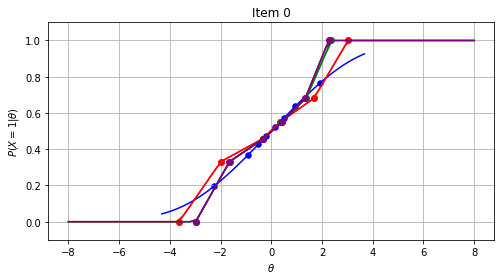

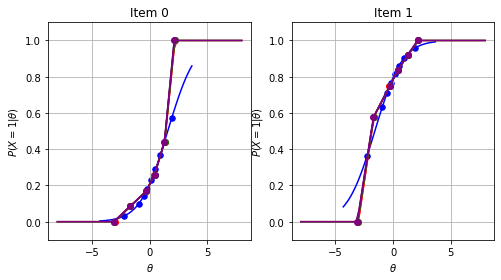

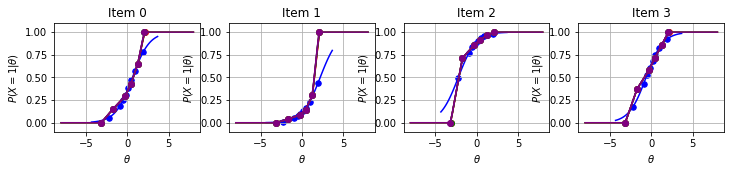

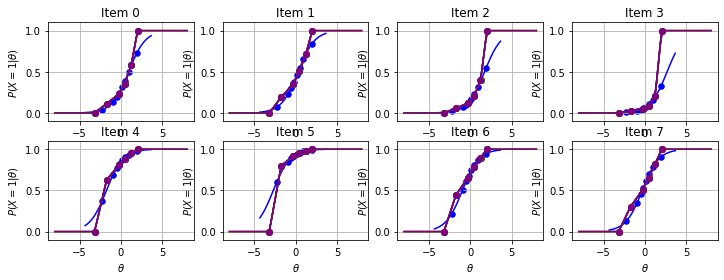

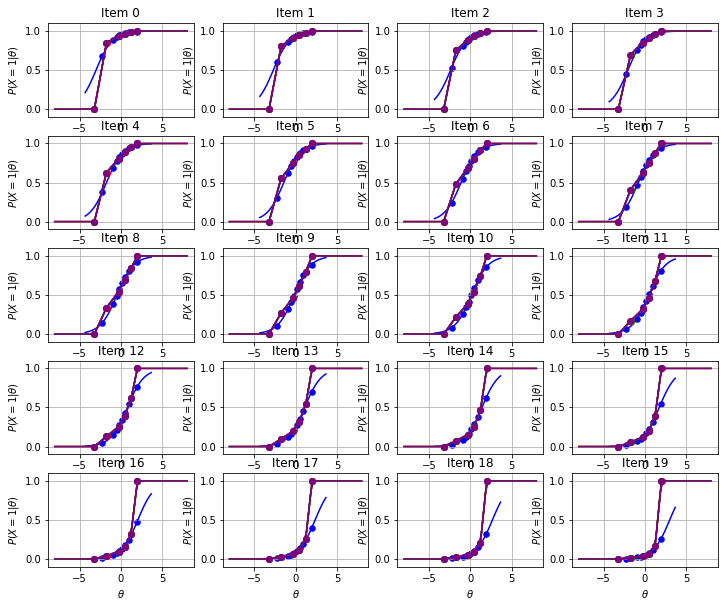

In [63]:
i = 0
item_levels = list(recorder.irf.keys())
#print("#items", item_levels)

for k, num_items in enumerate(item_levels):
    if num_items < 4:
        fig, axs = plt.subplots(1, num_items, figsize=(8, 4))
    else:
        fig, axs = plt.subplots(num_items // 4, 4, figsize=(12, 0.5 * num_items))
    cluster = solver._clustering[k]
    
    for i in range(num_items):
        ax = axs[i // 4, i % 4] if num_items > 4 else (axs[i] if num_items > 1 else axs)
        colors = ["red", "green", "purple", "orange"]
        cluster_model_irf = lambda t: np.array([model_irf[j](t) for j in cluster[i]]).mean(0)
        nirt.simulate.plot_irf.plot_model_irf(
            ax, grid_all[c[i]], cluster_model_irf, color="blue", label="Original")
        for l, irf in enumerate(recorder.irf[num_items]):
            irf[i].plot(ax, color=colors[l % len(colors)],
                        label="iter {} Error {:.2f}".format(
                            l, nirt.error.error_norm(cluster_model_irf, irf[i])))
        ax.set_title("Item {}".format(i))
        ax.grid(True)
        #ax.legend()

Some individual item IRFs have small kinks, but that's not a bad result at all.

### $\theta$ accuracy

In [64]:
print("Score-based estimate correlation: {:.5f}".format(
    np.corrcoef(theta_init[:, 0], theta_exact[:, 0])[0, 1]))
print("Final estimate correlation: {:.5f}".format(
    np.corrcoef(t[:, 0], theta_exact[:, 0])[0, 1]))

Score-based estimate correlation: 0.99915
Final estimate correlation: 0.97602


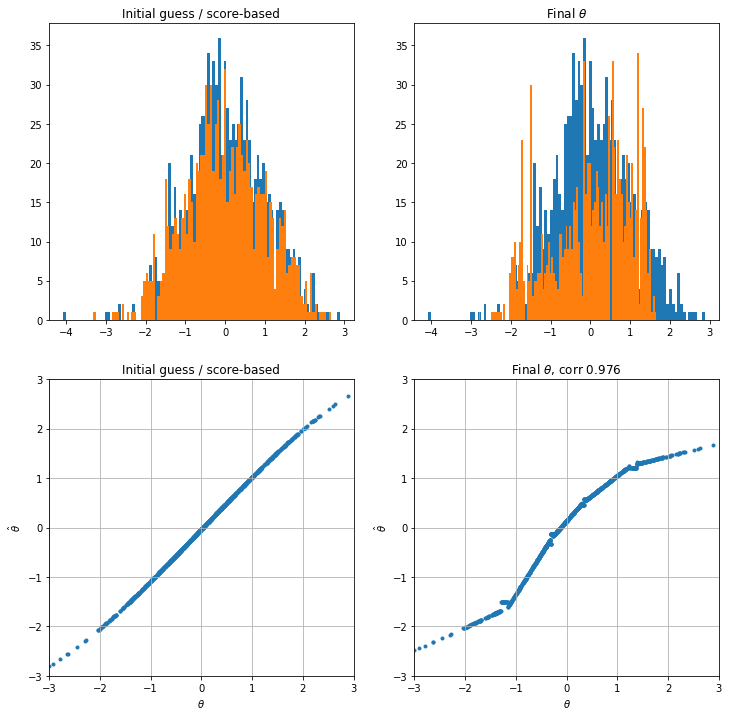

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

ax = axs[0, 0]
ax.hist(theta_exact, 100);
ax.hist(theta_init[:, 0], 100);
ax.set_title("Initial guess / score-based")


ax = axs[0, 1]
ax.hist(theta_exact, 100);
ax.hist(t[:, 0], 100);
ax.set_title(r"Final $\theta$");

ax = axs[1, 0]
ax.scatter(theta_exact[:, 0], theta_init[:, 0], marker='.');
ax.set_xlim([-3, 3]);
ax.set_ylim([-3, 3]);
ax.set_title("Initial guess / score-based".format(np.corrcoef(theta_exact[:, 0], theta_init[:, 0])[0, 1]))
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\hat{\theta}$")
ax.grid(True);

ax = axs[1, 1]
ax.scatter(theta_exact[:, 0], t[:, 0], marker='.');
ax.set_xlim([-3, 3]);
ax.set_ylim([-3, 3]);
ax.set_title(r"Final $\theta$, corr {:.3f}".format(np.corrcoef(theta_exact[:, 0], t[:, 0])[0, 1]))
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\hat{\theta}$")
ax.grid(True);

The $\hat{\theta}$ distribution has weird concentrations/spikes.

### Students with differnt $\theta$'s may have the same response pattern
So we can't hope for a corrleation $corr(\theta, \hat{\theta}) = 1$, but we should be doing better than score-based estimation.

In [66]:
# score = collections.Counter([tuple(t) for t in X])
# collections.Counter(score.values())

In [67]:
# identical = np.array(
#     [p for p, t in enumerate(X) 
#      if np.array_equal(t, np.array([k for k, v in score.items() if v == 5][0]))])
# print(identical)
# print(np.concatenate((theta_exact[identical], X[identical].mean(1)[:, None], theta_init[identical], t[identical]), axis=1))

## Example of $\theta_p$ Estimation using $L_2$ Loss

In [68]:
# Estimate thetas using X and the latest, individual-item IRFs.
irf = recorder.irf[20][-1]

theta_improver = nirt.theta_improvement.theta_improver_factory(
            solver._improve_theta_method, solver._num_theta_sweeps, loss=solver._loss, alpha=solver._alpha)
likelihood = nirt.likelihood.Likelihood(X, solver.c, irf)

active = np.arange(P, dtype=int)
person_ind = np.tile(active[:, None], C).flatten()
c_ind = np.tile(np.arange(C)[None, :], len(active)).flatten()
active_ind = (person_ind, c_ind)
theta_active = theta_improver.run(likelihood, t[active], active_ind)

In [69]:
theta_history = np.array([recorder.theta[20][k][:, 0] for k in range(len(recorder.theta[20]))])
p_max = np.argmax(np.abs(theta_history[-2] - theta_history[-1]))

194 [-4.078] [-2.806] [-2.937]


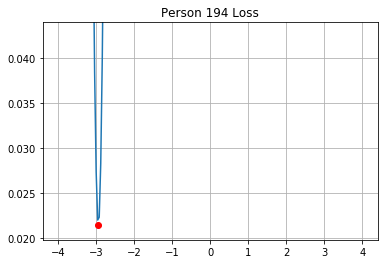

In [70]:
p = p_max

t_init = recorder.theta[20][-2][p]
print(p, theta_exact[p], t_init, theta_active[p])
xp = X[p]

mse_loss = lambda t: sum((irf[i].interpolant(t) - xp[i]) ** 2 for i in range(len(irf))) + alpha * (t - t_init) ** 2
t_continuous = np.linspace(-4, 4, 200)
y = mse_loss(t_continuous)

plt.plot(t_continuous, y);
plt.grid(True);
#plt.xlim([-0.8, 0.2]);
plt.ylim([0.9 * min(y), 2 * min(y)]);

plt.plot([theta_active[p]], [mse_loss(theta_active[p])], 'ro');
plt.title("Person {} Loss".format(p));

This person's $\theta_p$ changes quite a bit during iterations, whiile other $\theta$s are more stable, because there are multiple minima of similar value.

In [71]:
np.array([recorder.theta[20][k][p] for k in range(len(recorder.theta[20]))])

array([[-2.797],
       [-2.806],
       [-2.812]])

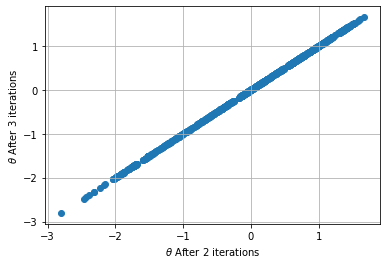

In [72]:
plt.scatter(theta_history[-2], theta_history[-1])
plt.xlabel(r"$\theta$ After {} iterations".format(num_iterations - 1))
plt.ylabel(r"$\theta$ After {} iterations".format(num_iterations))
plt.grid(True);

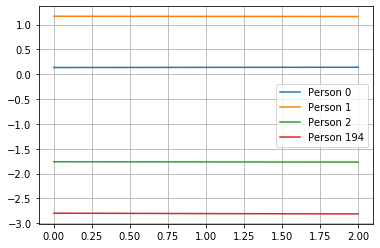

In [73]:
for p in range(3):
    plt.plot(theta_history[:, p], label="Person {}".format(p))
plt.plot(theta_history[:, p_max], label="Person {}".format(p_max))
plt.legend()
plt.grid(True);

Adding a regularization term $\alpha (\theta - \theta_0)$ to the $L_2$ loss (where $\theta_0$ is the value of $\theta$ before the update) solves this problem, but the overall correlation is still $0.8$.

## Subscale + IRF Resolution Refinement Solver
Refining the item cluster resolution and the IRFs at the same time during continuation steps.

In [74]:
# Run iterative refinement algorithm.
# v is fixed.
alpha = 0.0
recorder = nirt.run_recorder.RunRecorder()
coarsest_resolution = coarsest_resolution
solver = nirt.solver_item_clustering.SolverItemClustering(
    X, c, num_iterations=5, num_theta_sweeps=num_theta_sweeps, grid_method=grid_method,
    recorder=recorder, finest_resolution=16, coarsest_resolution=coarsest_resolution,
    theta_init=theta_exact, loss=loss, alpha=alpha, refine_irf=True)

INFO     Level	Nbhrs	Size	cr	mean_sz	std_sz	Time
INFO     1    	2    	2    	10.00  	10.0   	0.0    	0.00
INFO     2    	4    	4    	5.00   	5.0    	1.0    	0.00
INFO     3    	7    	8    	2.50   	2.5    	0.5    	0.00
INFO     4    	7    	16   	1.25   	1.2    	0.4    	0.00
INFO     5    	7    	18   	1.11   	1.1    	0.3    	0.00
INFO     Total						0.01
INFO     Trimming #neighbors to 5


In [75]:
t = solver.solve()

INFO     Initial guess range [-3.32, 2.67] mean 0.00 std 1.00
INFO     Solving at item clustering level with 1 items 4 bins
INFO     Iteration 1/5
INFO     Iteration 2/5
INFO     Iteration 3/5
INFO     Iteration 4/5
INFO     Iteration 5/5
INFO     Solving at item clustering level with 2 items 8 bins
INFO     Iteration 1/5
INFO     Iteration 2/5
INFO     Iteration 3/5
INFO     Iteration 4/5
INFO     Iteration 5/5
INFO     Solving at item clustering level with 4 items 16 bins
INFO     Iteration 1/5
INFO     Iteration 2/5
INFO     Iteration 3/5
INFO     Iteration 4/5
INFO     Iteration 5/5
INFO     Solving at item clustering level with 8 items 32 bins
INFO     Iteration 1/5
INFO     Iteration 2/5
INFO     Iteration 3/5
INFO     Iteration 4/5
INFO     Iteration 5/5
INFO     Solving at item clustering level with 20 items 64 bins
INFO     Iteration 1/5
INFO     Iteration 2/5
INFO     Iteration 3/5
INFO     Iteration 4/5
INFO     Iteration 5/5


In [85]:
# Run history: calculate the IRF error from the known parametric model.
logger.info("Initial guess / score-based estimation correlation: {:.3f}".format(
    np.corrcoef(theta_init[:, 0], theta_exact[:, 0])[0, 1]))

for k, (resolution, value) in enumerate(recorder.irf.items()):
    logger.info("#items {}".format(resolution))
    level = solver._clustering[k]
    cluster_model_irf = [
        lambda t, i=i: np.array([model_irf[j](t) for j in level[i]]).mean(0) 
        for i in range(resolution)]
    x = np.array([X[:, cluster].mean(1) for cluster in level]).transpose()

    e = nirt.error.error_norm_by_item(cluster_model_irf, numerical_irf)
    numerical_irf = solver._update_irf(coarsest_resolution * (2 ** k), theta_init, x=x)
    l2_loss = nirt.likelihood.Likelihood(x, c, numerical_irf).l2_loss(t)
    logger.info("Initial guess loss {:.7f}".format(l2_loss))

    for j in range(len(value)):
        numerical_irf = value[j]
        e = nirt.error.error_norm_by_item(cluster_model_irf, numerical_irf)
        t = recorder.theta[resolution][j]
        l2_loss = nirt.likelihood.Likelihood(x, c, numerical_irf).l2_loss(t)
        logger.info("IRF error: {:.3f} +- {:.3f}\tt range {:.3f}, {:.3f} corr {:.3f} loss {:.7f}".format(
            e.mean(), e.std(), t.min(), t.max(), 
            np.corrcoef(theta_exact[:, 0], t[:, 0])[0, 1], l2_loss))

INFO     Initial guess / score-based estimation correlation: 0.999
INFO     #items 1
INFO     Initial guess loss 0.0018970
INFO     IRF error: 0.059 +- 0.000	t range -3.318, 2.671 corr 0.999 loss 0.0010949
INFO     IRF error: 0.032 +- 0.000	t range -2.629, 2.022 corr 0.990 loss 0.0001546
INFO     IRF error: 0.032 +- 0.000	t range -2.607, 1.910 corr 0.987 loss 0.0001296
INFO     IRF error: 0.033 +- 0.000	t range -2.624, 1.854 corr 0.985 loss 0.0001280
INFO     IRF error: 0.033 +- 0.000	t range -2.650, 1.819 corr 0.984 loss 0.0001294
INFO     #items 2
INFO     Initial guess loss 0.0010892
INFO     IRF error: 0.030 +- 0.011	t range -2.728, 1.707 corr 0.982 loss 0.0001264
INFO     IRF error: 0.030 +- 0.008	t range -2.833, 1.666 corr 0.981 loss 0.0000292
INFO     IRF error: 0.033 +- 0.009	t range -2.912, 1.620 corr 0.978 loss 0.0000364
INFO     IRF error: 0.036 +- 0.009	t range -2.978, 1.575 corr 0.975 loss 0.0000414
INFO     IRF error: 0.038 +- 0.009	t range -3.037, 1.531 corr 0.972 loss 0

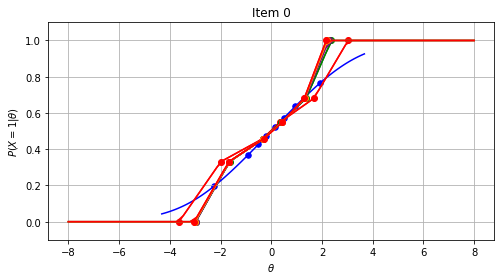

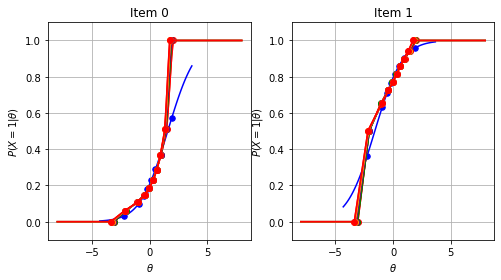

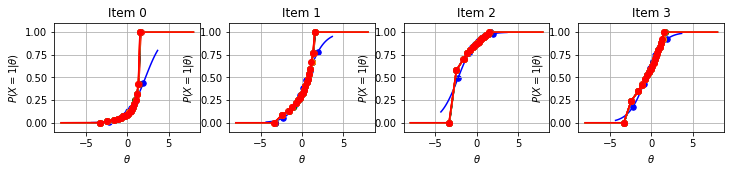

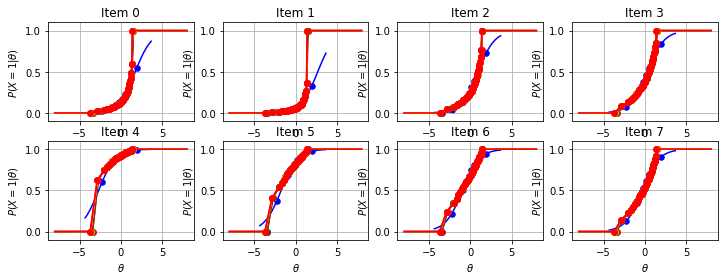

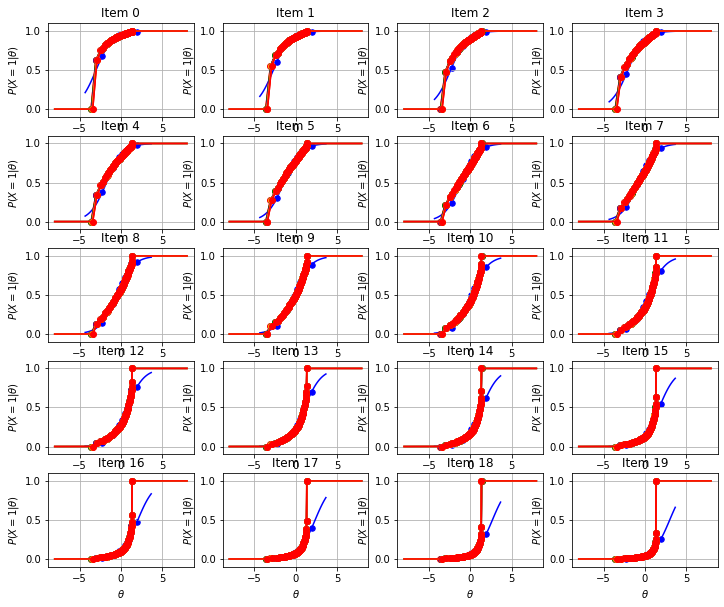

In [54]:
i = 0
item_levels = list(recorder.irf.keys())
#print("#items", item_levels)

for k, num_items in enumerate(item_levels):
    if num_items < 4:
        fig, axs = plt.subplots(1, num_items, figsize=(8, 4))
    else:
        fig, axs = plt.subplots(num_items // 4, 4, figsize=(12, 0.5 * num_items))
    cluster = solver._clustering[k]
    
    for i in range(num_items):
        ax = axs[i // 4, i % 4] if num_items > 4 else (axs[i] if num_items > 1 else axs)
        colors = ["red", "green", "purple", "orange"]
        cluster_model_irf = lambda t: np.array([model_irf[j](t) for j in cluster[i]]).mean(0)
        nirt.simulate.plot_irf.plot_model_irf(
            ax, grid_all[c[i]], cluster_model_irf, color="blue", label="Original")
        for l, irf in enumerate(recorder.irf[num_items]):
            irf[i].plot(ax, color=colors[l % len(colors)],
                        label="iter {} Error {:.2f}".format(
                            l, nirt.error.error_norm(cluster_model_irf, irf[i])))
        ax.set_title("Item {}".format(i))
        ax.grid(True)
        #ax.legend()

The $\theta$ correlation is even lower, and IRFs develop kinks are the resolution is refined.

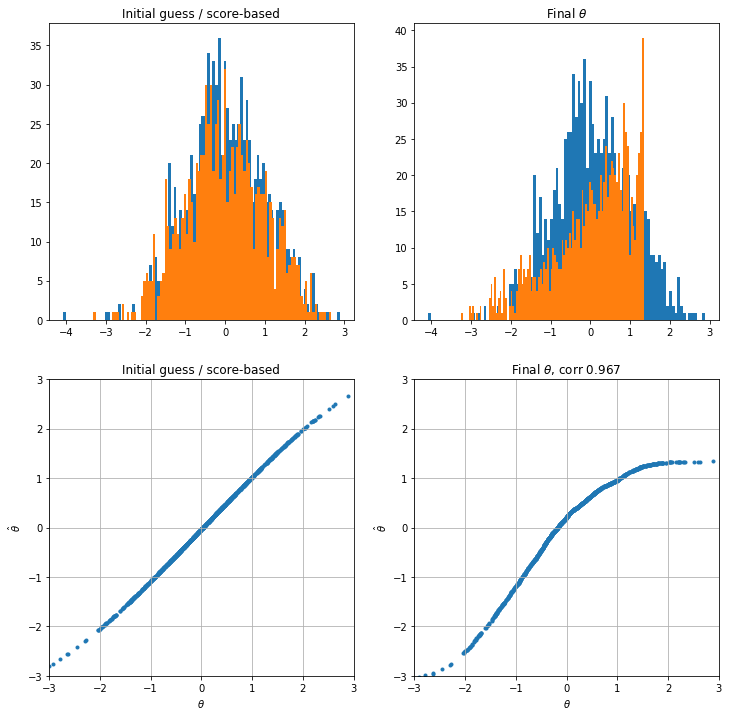

In [86]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

ax = axs[0, 0]
ax.hist(theta_exact, 100);
ax.hist(theta_init[:, 0], 100);
ax.set_title("Initial guess / score-based")


ax = axs[0, 1]
ax.hist(theta_exact, 100);
ax.hist(t[:, 0], 100);
ax.set_title(r"Final $\theta$");

ax = axs[1, 0]
ax.scatter(theta_exact[:, 0], theta_init[:, 0], marker='.');
ax.set_xlim([-3, 3]);
ax.set_ylim([-3, 3]);
ax.set_title("Initial guess / score-based".format(np.corrcoef(theta_exact[:, 0], theta_init[:, 0])[0, 1]))
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\hat{\theta}$")
ax.grid(True);

ax = axs[1, 1]
ax.scatter(theta_exact[:, 0], t[:, 0], marker='.');
ax.set_xlim([-3, 3]);
ax.set_ylim([-3, 3]);
ax.set_title(r"Final $\theta$, corr {:.3f}".format(np.corrcoef(theta_exact[:, 0], t[:, 0])[0, 1]))
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\hat{\theta}$")
ax.grid(True);

## Checking Solution Consistency
We assume that the center of the bin is the mean of $P_i(\theta)$ over the bin. This is appoximately true for any smooth IRF, but not exact. For a bin of size $h$, the error is $O(h^2)$.

In [77]:
A, B = discrimination, b[5]

In [78]:
A, B

(1, -1.4210526315789473)

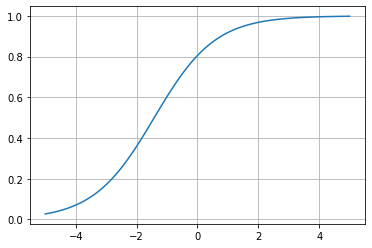

In [20]:
t = np.linspace(-5, 5, 100)
plt.plot(t, model_irf[5](t))
plt.grid(True);

In [80]:
# Print some (t1,t2) intervals, the exact 2PL model's central value, bin average (exact integral),
# and differrence. As resolution n increases, this is an O(n^(-2)) difference.
for n in 2 ** np.arange(2, 6):
    print(n)
    bins = np.linspace(-5, 5, n + 1)
    for i in range(n):
        t1, t2 = bins[i], bins[i + 1]
        bin_mean = 1 + np.log((np.exp(-A*(t2-B)) + 1) / (np.exp(-A*(t1-B)) + 1)) / (A * (t2 - t1))
        bin_center_value = 1 / (1 + np.exp(-A*(0.5*(t1+t2)-B)))
        print(t1, t2, bin_mean, bin_center_value, np.abs(bin_center_value - bin_mean))

4
-5.0 -2.5 0.1060447479371096 0.08875375959866978 0.017290988338439825
-2.5 0.0 0.5378823332676073 0.5426591947902129 0.004776861522605591
0.0 2.5 0.9213353921874293 0.935296762408952 0.013961370221522662
2.5 5.0 0.992799705400764 0.9943534760733931 0.0015537706726290734
8
-5.0 -3.75 0.05233545288545982 0.049550279153043573 0.0027851737324162476
-3.75 -2.5 0.1597540429887594 0.15395041897670864 0.0058036240120507565
-2.5 -1.25 0.39175339712961366 0.3884226547636419 0.0033307423659717506
-1.25 0.0 0.6840112694056009 0.6891294681692418 0.0051181987636409465
0.0 1.25 0.8804828242780235 0.8855481510446886 0.005065326766665157
1.25 2.5 0.9621879600968353 0.9642931442435626 0.0021051841467273347
2.5 3.75 0.9888289348685626 0.9895023698835631 0.0006734350150005008
3.75 5.0 0.9967704759329654 0.9969696815039796 0.00019920557101416048
16
-5.0 -4.375 0.037275537144624615 0.0367403509576438 0.0005351861869808128
-4.375 -3.75 0.06739536862629492 0.06651810707240866 0.0008772615538862605
-3.75 -3.